# 21点游戏的蒙特卡洛学习

### 示例：二十一点游戏 Blackjack Example
该示例解释了Model-Free下的策略评估问题和结果，没有说具体的学习过程。

状态空间：（多达200种，根据对状态的定义可以有不同的状态空间，这里采用的定义是牌的分数，不包括牌型）由三个维度构成：

当前牌的分数（12 - 21），低于12时，你可以安全的再叫牌，所以没意义。

庄家出示的牌（A - 10），庄家会显示一张牌面给玩家

我有“useable” ace吗？（是或否）A既可以当1点也可以当11点。

行为空间：

  停止要牌 stick
  
  继续要牌 twist
  
奖励（停止要牌）：

+1：如果你的牌分数大于庄家分数

0： 如果两者分数相同

-1：如果你的牌分数小于庄家分数


奖励（继续要牌）：

-1：如果牌的分数>21，并且进入终止状态

0：其它情况


状态转换（Transitions）：如果牌分小于12时，自动要牌

当前策略：牌分只要小于20就继续要牌。

求解问题：评估该策略的好坏。


求解过程：使用庄家显示的牌面值、玩家当前牌面总分值来确定一个二维状态空间，区分手中有无A分别处理。统计每一牌局下决定状态的庄家和玩家牌面的状态数据，同时计算其最终收获。通过模拟多次牌局，计算每一个状态下的平均值，得到如下图示。
最终结果：无论玩家手中是否有A牌，该策略在绝大多数情况下各状态价值都较低，只有在玩家拿到21分时状态价值有一个明显的提升。

## 1. 蒙特卡罗预测

In [1]:
from random import shuffle
from queue import Queue
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from utils import str_key, set_dict, get_dict

In [2]:
A = ["继续叫牌","停止叫牌"]  
#A = [0,1]  
def value_of(card):
    '''根据牌的字符判断牌的数值大小，A被输出为1, JQK均为10，其余按牌字符对应的数字取值
    Args:
        card: 牌面信息 str
    Return:
        牌的大小数值 int, A 返回 1
    '''
    try:
        v = int(card)
    except:
        if card == 'A':
            v = 1
        elif card in ['J','Q','K']:
            v = 10
        else:
            v = 0
    finally:
        return v

def points_of(cards):
    '''统计一手牌分值，如果使用了A的1点，同时返回True
    Args:
        cards 庄家或玩家手中的牌 list ['A','10','3']
    Return
        tuple (返回牌总点数,是否使用了可复用Ace) 
        例如['A','10','3'] 返回 (14, True)
           ['A','10'] 返回 （21, False)
    '''
    num_of_useable_ace = 0 # 默认没有拿到Ace
    total_point = 0 # 总值
    if cards is None:
        return 0, False
    for card in cards:
        v = value_of(card)
        if v == 1:
            num_of_useable_ace += 1
            v = 11
        total_point += v
    while total_point > 21 and num_of_useable_ace > 0:
        total_point -= 10
        num_of_useable_ace -= 1
    return total_point, bool(num_of_useable_ace)
    
def get_state(dealer, player):
    '''显示完整的状态，包括庄家的总分、玩家的总分、玩家是否有useable_ace
    '''
    player_points, useable_ace = points_of(player.cards)
    #dealer = list(dealer) # 考虑到dealer只传第一张牌字符串的情况
    dealer_points, _ = points_of(dealer.cards)
    return dealer_points, player_points, int(useable_ace)

def get_state_name(dealer, player):
    '''只获得庄家的第一张牌信息和总点数信息，以及有无useable_ace，形成字符串作为字典键
    '''
    player_points, useable_ace = points_of(player.cards)
    first_dealer_card = 0
    if dealer.cards is None or len(dealer.cards) == 0:
        pass
    else:
        first_dealer_card = value_of(dealer.cards[0])
    return str(first_dealer_card) + "_" + str(player_points) + "_" + str(int(useable_ace))


def reward_of(dealer, player):
    '''判断玩家奖励值，附带玩家、庄家的牌点信息
    '''
    dealer_points, _ = points_of(dealer.cards)
    player_points, useable_ace = points_of(player.cards)
    if player_points > 21:
        reward = -1
    else:
        if player_points > dealer_points or dealer_points > 21:
            reward = 1
        elif player_points == dealer_points:
            reward = 0
        else:
            reward = -1
    return reward, player_points, dealer_points, useable_ace



In [3]:
# 辅助函数：读取字典
def str_key(*args):
    '''将参数用"_"连接起来作为字典的键，需注意参数本身不是基本数据类型，而是tuple或者list型，
    比如类似((a,b,c),d)的形式。
    '''
    new_arg = []
    for arg in args:
        if type(arg) in [tuple, list]:
            new_arg += [str(i) for i in arg]
        else:
            new_arg.append(str(arg))
    return "_".join(new_arg)

def set_dict(target_dict, value, *args):
    target_dict[str_key(*args)] = value

def get_dict(target_dict, *args):
    #print("key: {}".format(str_key(*args)))
    return target_dict.get(str_key(*args),0)

In [4]:
print(str_key(10,20,(0,0)))
print(str_key((10,20),(0,1)))
print(str_key(10,20,0,1))
print(str_key(0,20,0,1))
print(str_key((0,20,0,1)))

10_20_0_0
10_20_0_1
10_20_0_1
0_20_0_1
0_20_0_1


In [5]:
class Person():
    def __init__(self, name=""):
        self.name = name
    
    def __str__(self):
        return self.name

class Player(Person):
    def __init__(self, policy = None, name="", role = "", display = False, A = A):
        super(Player, self).__init__(name)
        self.cards = [] # 玩家手中的牌
        self.policy = policy # 策略
        self.Q = {}   # 某一状态行为对的价值
        self.Nsa = {} # Nsa的计数：某一状态行为对出现的次数
        self.role = role # “庄家”还是“玩家”，庄家是特殊的玩家
        self.A = A #行为空间
        self.display = display # 是否使用print输出信息了解战局或计算情况
        self.total_learning_times = 0
     
    def receive(self, cards = []): # 玩家获得一张或多张牌
        cards = list(cards)
        for card in cards:
            self.cards.append(card)
    
    def discharge_cards(self): # 玩家把手中的牌清空，扔牌
        '''扔牌
        '''
        self.cards.clear()
    
    def cards_info(self): # 玩家手中牌的信息
        '''
        显示牌面具体信息
        '''
        self._info("{}{}现在的牌:{}\n".format(self.role, self,self.cards))
    
    def _info(self, msg):
        if self.display:
            print(msg, end="")
            
    def learn_Q(self, episode, r): # 从状态序列来学习Q值
        '''从Episode学习
        '''
        #for episode, r in episodes:
        for s, a in episode:
            nsa = get_dict(self.Nsa, s, a)
            set_dict(self.Nsa, nsa+1, s, a)
            q = get_dict(self.Q, s,a)
            set_dict(self.Q, q+(r-q)/(nsa+1), s, a)
        self.total_learning_times += 1
    
    def reset_memory(self):
        '''忘记既往学习经历
        '''
        self.Q.clear()
        self.Nsa.clear()
        self.total_learning_times = 0


In [6]:
class Arena():
    '''负责游戏管理
    '''
    def __init__(self, display = None, A = A):
        self.cards = ['A','2','3','4','5','6','7','8','9','10','J','Q',"K"]*4
        self.card_q = Queue(maxsize = 52) # 洗好的牌
        self.cards_in_pool = [] # 已经用过的公开的牌  
        self.display = display
        self.episodes = [] # 产生的对局信息列表
        self.load_cards(self.cards)# 把初始状态的52张牌装入发牌器
        self.A = A # 获得行为空间
        
    def play_game(self, dealer, player):
        '''玩一局21点，生成一个状态序列以及最终奖励（中间奖励为0）
        Args：
            dealer/player 庄家和玩家手中的牌 list
        Returns:
            tuple：episode, reward
        '''
        #self.collect_player_cards()
        self._info("========= 开始新一局 =========\n")
        self.serve_card_to(player, n=2) # 发两张牌给玩家
        self.serve_card_to(dealer, n=2) # 发两张牌给庄家
        episode = [] # 记录一个对局信息
        if player.policy is None:
            self._info("玩家需要一个策略")
            return
        if dealer.policy is None:
            self._info("庄家需要一个策略")
            return
        while True:
            s = get_state(dealer = dealer, player = player) # 获取状态信息
            #epsilon = 1.0/(1 + math.sqrt(1 + player.total_learning_times))
            epsilon = 1.0/(1 + 10 * math.log10(1+player.total_learning_times))
            action = player.policy(player.A, s, player.Q, epsilon)
            # 玩家的策略产生一个行为
            self._info("{}{}选择:{};".format(player.role, player, action))
            if action == self.A[0]: # 继续叫牌
                episode.append((get_state_name(dealer, player), action)) # 记录一个(s,a)
                self.serve_card_to(player) # 发一张牌给玩家
            else: # 停止叫牌
                episode.append((get_state_name(dealer, player), self.A[1])) # 记录一个(s,a)
                break
        # 玩家停止叫牌后要计算下玩家手中的点数，玩家如果爆了，庄家就不用继续了        
        reward, player_points, dealer_points, useable_ace = reward_of(dealer, player)
        
        if player_points > 21:
            self._info("玩家爆点{}输了，得分:{}\n".format(player_points, reward))
            self.recycle_cards(player, dealer)
            self.episodes.append((episode, reward)) # 预测的时候需要形成episode list后同一学习V
            # 在蒙特卡洛控制的时候，可以不需要episodes list,生成一个episode学习一个，下同
            self._info("========= 本局结束 ==========\n")
            return episode, reward
        # 玩家并没有超过21点
        self._info("\n")
        while True:
            s = get_state(dealer = dealer, player = player) # 获取状态信息
            action = dealer.policy(self.A, s, None, None) # 庄家从其策略中获取一个行为
            self._info("{}{}选择:{};".format(dealer.role, dealer, action))
            if action == self.A[0]: # 庄家"继续要牌":
                self.serve_card_to(dealer)
                # 停止要牌是针对玩家来说的，episode不记录庄家动作
                # 在状态只记录庄家第一章牌信息时，可不重复记录(s,a)，因为此时玩家不再叫牌，(s,a)均相同
                # episode.append((get_state_name(dealer, player), self.A[1]))
            else:
                break
        # 双方均停止叫牌了    
        self._info("\n双方均了停止叫牌;\n")
        reward, player_points, dealer_points, useable_ace = reward_of(dealer, player)
        player.cards_info() 
        dealer.cards_info()
        if reward == +1:
            self._info("玩家赢了!")
        elif reward == -1:
            self._info("玩家输了!")
        else:
            self._info("双方和局!")
        self._info("玩家{}点,庄家{}点\n".format(player_points, dealer_points))
        
        self._info("========= 本局结束 ==========\n")
        self.recycle_cards(player, dealer) # 回收玩家和庄家手中的牌至公开牌池
        self.episodes.append((episode, reward)) # 将刚才产生的完整对局添加值状态序列列表，蒙特卡洛控制不需要
        return episode, reward
    
    def play_games(self, dealer, player, num=2, show_statistic = False):
        '''一次性玩多局游戏
        '''
        results = [0, 0, 0]# 玩家负、和、胜局数
        self.episodes.clear()
        for i in tqdm(range(num)):
            episode, reward = self.play_game(dealer, player)
            results[1+reward] += 1
            player.learn_Q(episode ,reward)
        if show_statistic:
            print("共玩了{}局，玩家赢{}局，和{}局，输{}局，胜率：{:.2f}"\
              .format(num, results[2],results[1],results[0],results[2]/num))
        pass
        
    def load_cards(self, cards):
        '''把收集的牌洗一洗，重新装到发牌器中
        Args:
            cards 要装入发牌器的多张牌 list
        Return:
            None
        '''
        shuffle(cards) # 洗牌
        for card in cards:# deque数据结构只能一个一个添加
            self.card_q.put(card)
        cards.clear() # 原来的牌清空
        return
    
    
    def serve_card_to(self, player, n = 1):
        '''给庄家或玩家发牌，如果牌不够则将公开牌池的牌洗一洗重新发牌
        Args:
            player 一个庄家或玩家 
            n 一次连续发牌的数量
        Return:
            None
        '''
        cards = []  #将要发出的牌
        for _ in range(n):
            # 要考虑发牌器没有牌的情况
            if self.card_q.empty():
                self._info("\n发牌器没牌了，整理废牌，重新洗牌;")
                shuffle(self.cards_in_pool)
                self._info("一共整理了{}张已用牌，重新放入发牌器\n".format(len(self.cards_in_pool)))
                assert(len(self.cards_in_pool) > 20) # 确保有足够的牌，将该数值设置成40左右时，如果玩家
                # 即使爆点了也持续的叫牌，会导致玩家手中牌变多而发牌器和已使用的牌都很少，需避免这种情况。
                self.load_cards(self.cards_in_pool) # 将收集来的用过的牌洗好送入发牌器重新使用
            cards.append(self.card_q.get()) # 从发牌器发出一章牌
        self._info("发了{}张牌({})给{}{};".format(n, cards, player.role, player))
        #self._info(msg)
        player.receive(cards) # 牌已发给某一玩家
        player.cards_info()

    def recycle_cards(self, *players):
        '''回收玩家手中的牌到公开使用过的牌池中
        '''
        if len(players) == 0:
            return
        for player in players:
            for card in player.cards:
                self.cards_in_pool.append(card)
            player.discharge_cards() # 玩家手中不再留有这些牌
            
    def _info(self, message):
        if self.display:
            print(message, end="")

In [7]:
def policy_for_dealer(A, s, Q = None, k = None):
    '''庄家策略,不同的策略需要的参数不一样，这是玩家所能参考的最多的信息
    Args:
        A 行为空间 list []
        s 状态空间 s = (dealer_points, player_points, useable_ace) tuple
        Q 行为价值字典 {}
        k 对局的次数，用于计算epsilon-greedy算法中的epsilon
    '''
    dealer_points, player_points, useable_ace = s
    action = ""
    if dealer_points >= 17:#or player_points > 21:
        action = A[1] # "停止要牌"
    else:
        action = A[0]
    #elif dealer_points < player_points:
    #    action = A[0] # "继续要牌"
    #else:
    #    action = A[1] # "停止要牌"
    return action


def naive_policy(A, s, Q = None, k = None):
    '''原始策略，玩家只要手中的牌值低于20就会持续叫牌
    '''
    _, player_points, _ = s
    action = ""
    if player_points < 20:
        action = A[0]
    else:
        action = A[1]        
    return action  


In [8]:
display = False
# 创建一个玩家一个庄家，玩家使用原始策略，庄家使用其固定的策略
player = Player(policy = naive_policy, role="玩家", display = display)
dealer = Player(policy = policy_for_dealer, role = "庄家", display = display)
# 创建一个场景
arena = Arena(display=display)
# 生成num个完整的对局

In [9]:
arena.play_games(dealer, player, num=20000)

100%|██████████| 20000/20000 [00:02<00:00, 8617.55it/s]


In [10]:
# 统计个状态的价值，衰减因子为1，中间状态的即时奖励为0，递增式蒙特卡洛评估
def learn_V(episodes, V, Ns):
    for episode, r in episodes:
        for s, a in episode:
            ns = get_dict(Ns, s)
            v = get_dict(V, s)
            set_dict(Ns, ns+1, s)
            set_dict(V, v+(r-v)/(ns+1), s)
        

In [11]:
V = {} # 状态价值字典
Ns = {} # 状态被访问的次数节点
learn_V(arena.episodes, V, Ns) # 学习V值

In [12]:
def draw_value(value_dict, useable_ace = 0, is_q_dict = False, A = None):
    # 定义figure
    fig = plt.figure()
    # 将figure变为3d
    ax = Axes3D(fig)
    # 定义x, y
    x = np.arange(1, 11, 1) # 庄家第一张牌
    y = np.arange(12, 22, 1) # 玩家总分数
    # 生成网格数据
    X, Y = np.meshgrid(x, y)
    # 从V字典检索Z轴的高度
    row, col = X.shape
    Z = np.zeros((row,col))
    if is_q_dict:
        n = len(A)
    for i in range(row):
        for j in range(col):
            state_name = str(X[i,j])+"_"+str(Y[i,j])+"_"+str(useable_ace)
            if not is_q_dict:
                Z[i,j] = get_dict(value_dict, state_name)
            else:
                assert(A is not None)
                for a in A:
                    new_state_name = state_name + "_" + str(a)
                    q = get_dict(value_dict, new_state_name)
                    if q >= Z[i,j]:
                        Z[i,j] = q
    # 绘制3D曲面
    ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, cmap = plt.cm.cool)
    plt.show()

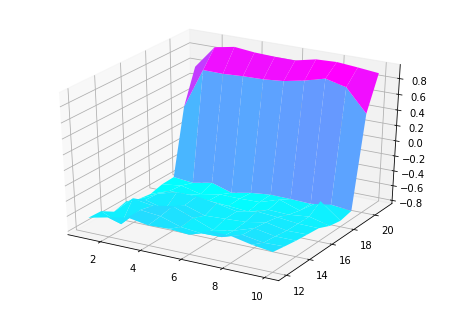

In [13]:
draw_value(V) # 绘制状态价值图

## 2. 蒙特卡洛控制

In [14]:
import random    # 随机策略时用到

def greedy_pi(A, s, Q, a):
    '''依据贪婪选择，计算在行为空间A中，状态s下，a行为被贪婪选中的几率
    考虑多个行为的价值相同的情况
    '''
    #print("in greedy_pi: s={},a={}".format(s,a))
    max_q, a_max_q = -float('inf'), []
    for a_opt in A:# 统计后续状态的最大价值以及到达到达该状态的行为（可能不止一个）
        q = get_dict(Q, s, a_opt)
        #print("get q from dict Q:{}".format(q))
        if q > max_q:
            max_q = q
            a_max_q = [a_opt]
        elif q == max_q:
            #print("in greedy_pi: {} == {}".format(q,max_q))
            a_max_q.append(a_opt)
    n = len(a_max_q)
    if n == 0: return 0.0
    return 1.0/n if a in a_max_q else 0.0

def greedy_policy(A, s, Q):
    """在给定一个状态下，从行为空间A中选择一个行为a，使得Q(s,a) = max(Q(s,))
    考虑到多个行为价值相同的情况
    """
    max_q, a_max_q = -float('inf'), []
    for a_opt in A:
        q = get_dict(Q, s, a_opt)
        if q > max_q:
            max_q = q
            a_max_q = [a_opt]
        elif q == max_q:
            a_max_q.append(a_opt)
    return random.choice(a_max_q)
        
def epsilon_greedy_pi(A, s, Q, a, epsilon = 0.1):
    m = len(A)
    greedy_p = greedy_pi(A, s, Q, a)
    #print("greedy prob:{}".format(greedy_p))
    if greedy_p == 0:
        return epsilon / m
    n = int(1.0/greedy_p)
    return (1 - epsilon) * greedy_p + epsilon/m


def epsilon_greedy_policy(A, s, Q, epsilon, show_random_num = False):
    pis = []
    m = len(A)
    for i in range(m):
        pis.append(epsilon_greedy_pi(A, s, Q, A[i], epsilon))
    rand_value = random.random() # 产生一个0,1的随机数
    #if show_random_num:
    #    print("产生的随机数概率为:{:.2f}".format(rand_value))
    #print(rand_value)
    for i in range(m):
        if show_random_num:
            print("随机数:{:.2f}, 拟减去概率{}".format(rand_value, pis[i]))
        rand_value -= pis[i]
        if rand_value < 0:
            return A[i]

def epsilon_greedy_black_jack_policy(A, s, Q, epsilon, show_random_num = False):
    _, player_points, _ = s
    if player_points >= 21:
        return A[1]
    if player_points < 12:
        return A[0]
    else:
        return epsilon_greedy_policy(A, s, Q, epsilon, show_random_num)


In [15]:
# 测试上面三个函数
test_S = [str(i) for i in range(10)] # 10个状态
test_A = [str(i) for i in range(3)] # 3个行为
test_Q = {}
for s in test_S:
    for a in test_A:
        set_dict(test_Q, random.random(), s, a)

In [16]:
def Q_of_s(A, s, Q):
    qs = []
    for i in range(len(A)):
        qs.append(get_dict(Q, s, A[i]))
    return qs

       
def verify_greedy_policy(A, S, Q):
    for s in S:
        qs = Q_of_s(A, s, Q)
        print("Q({},)={}".format(s,qs))
        a = greedy_policy(A, s, Q)
        qsa = get_dict(Q, s, a)
        max_qs = max(qs)
        print("q({},{}) = {},{}".format(s, a, qsa, max_qs))
        if qsa == max(qs):
            print("verified")
        else:
            print("wrong")

In [17]:
test_Q['3_0'], test_Q['3_1'], test_Q['3_2'] = 0.2,0.4,0.5
s,a = '3','1'
epsilon_greedy_policy(test_A, s, test_Q, epsilon=0.1)

'2'

In [18]:
def draw_policy(policy, A, Q, epsilon, useable_ace = 0):
    def value_of(a):
        if a == A[0]:
            return 0
        else:
            return 1
    rows, cols = 11, 10
    Z = np.zeros((rows, cols))
    dealer_first_card = np.arange(1, 12) # 庄家第一张牌
    player_points = np.arange(12,22)
    for i in range(rows): # 庄家第一张牌 1,12
        for j in range(cols): # 玩家总牌分 12,22
            s = j + 1, i + 11, useable_ace
            a = policy(A, s, Q, epsilon)
            Z[i,j] = value_of(a)
    
    plt.imshow(Z, cmap=plt.cm.cool, interpolation=None, origin="lower", extent=[1, 11, 11, 22])


In [19]:
display = False
# 创建一个玩家一个庄家，玩家使用原始策略，庄家使用其固定的策略
player = Player(policy = naive_policy, role="玩家", display = display)
dealer = Player(policy = policy_for_dealer, role = "庄家", display = display)
# 创建一个场景
arena = Arena(display=display)
player.policy = epsilon_greedy_black_jack_policy
#player.reset_memory()

In [20]:
arena.display = False
player.display = False
dealer.display = False
player.policy = epsilon_greedy_black_jack_policy
arena.play_games(dealer=dealer, player=player, num = 1000000, show_statistic = True)

100%|██████████| 1000000/1000000 [02:05<00:00, 7944.22it/s]

共玩了1000000局，玩家赢341701局，和57293局，输601006局，胜率：0.34


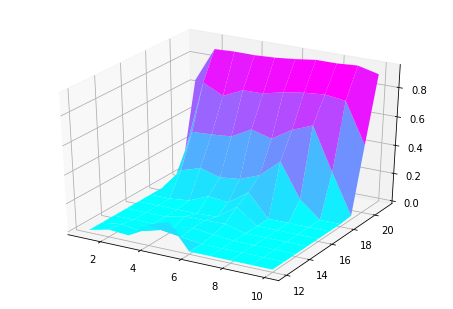

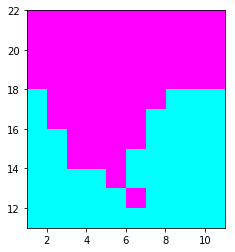

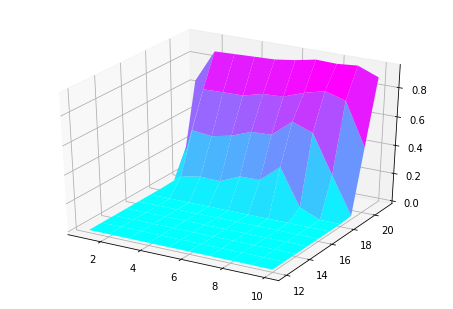

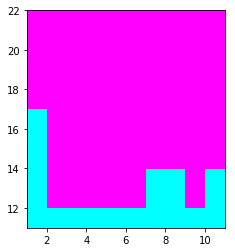

In [21]:
draw_value(player.Q, useable_ace = 1, is_q_dict=True, A = player.A)
draw_policy(player.policy, A, player.Q, epsilon = 1e-10, useable_ace = 1)
draw_value(player.Q, useable_ace = 0, is_q_dict=True, A = player.A)
draw_policy(player.policy, A, player.Q, epsilon = 1e-10, useable_ace = 0)

In [22]:
arena.display = False
player.display = False
dealer.display = False
player.policy = epsilon_greedy_black_jack_policy #naive_policy # 
arena.play_games(dealer,player,num=10000, show_statistic = True)

100%|██████████| 10000/10000 [00:01<00:00, 8045.35it/s]

共玩了10000局，玩家赢3440局，和590局，输5970局，胜率：0.34


In [23]:
display = False
arena.display = display
player.display = display
dealer.display = display
player.policy = epsilon_greedy_black_jack_policy
arena.play_games(dealer,player,num=1000, show_statistic = True)

100%|██████████| 1000/1000 [00:00<00:00, 7096.76it/s]

共玩了1000局，玩家赢347局，和57局，输596局，胜率：0.35


In [24]:
player.total_learning_times

1011000

In [25]:
s = 9, 12, 1
print(player.A)

print(player.Q[str_key(s,player.A[0])])
print(player.Q[str_key(s,player.A[1])])
s = 10, 15, 0
print(player.Q[str_key(s,player.A[0])])
print(player.Q[str_key(s,player.A[1])])

print(player.Nsa[str_key("6_18_0", player.A[0])])
print(player.Nsa[str_key("6_18_0", player.A[0])])
epsilon_greedy_black_jack_policy(player.A, s, player.Q, 1e-10, show_random_num = True)

['继续叫牌', '停止叫牌']
-0.24074074074074056
-0.5176470588235298
-0.6469173965309978
-0.5699084668192236
3115
3115
随机数:0.80, 拟减去概率5e-11
随机数:0.80, 拟减去概率0.99999999995


'停止叫牌'